In [20]:
!pip install shap
!pip uninstall xgboost -y
!pip install xgboost==1.7.6

Found existing installation: xgboost 1.7.6
Uninstalling xgboost-1.7.6:
  Successfully uninstalled xgboost-1.7.6
  Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl.metadata (1.9 kB)
Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl (200.3 MB)


In [21]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))
import config

# Settings
np.random.seed(config.RANDOM_STATE)
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


#### Data Preparation

In [22]:
# Load and clean data
df = pd.read_csv(config.RAW_DATA_FILE, delimiter=';')

In [23]:
# Cleaning
df['age'] = (df['age'] / 365.25).round().astype(int)
df = df[(df['ap_hi'] > 0) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 0) & (df['ap_lo'] < 200)]
df = df[df['ap_hi'] > df['ap_lo']]
df = df[(df['height'] > 120) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]

In [24]:
# Feature Engineering
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['map'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3
df['health_risk_score'] = (
    (df['cholesterol'] - 1) * 2 + (df['gluc'] - 1) * 2 + 
    df['smoke'] * 3 + df['alco'] * 2 - df['active'] * 2
)
df['gender_age_interaction'] = df['gender'] * df['age']
df['weight_height_ratio'] = df['weight'] / df['height']
df['chol_gluc_interaction'] = df['cholesterol'] * df['gluc']

In [25]:
# Categorical features
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 100],
                         labels=['young', 'middle', 'senior', 'elderly'])
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100],
                            labels=['underweight', 'normal', 'overweight', 'obese'])

def bp_category(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 'normal'
    elif row['ap_hi'] < 130 and row['ap_lo'] < 80:
        return 'elevated'
    elif row['ap_hi'] < 140 or row['ap_lo'] < 90:
        return 'hypertension_stage1'
    else:
        return 'hypertension_stage2'

df['bp_category'] = df.apply(bp_category, axis=1)

In [26]:
# Encoding
df_encoded = pd.get_dummies(df, columns=['age_group', 'bmi_category', 'bp_category'], 
                            drop_first=True)

In [27]:
# Prepare features and target
feature_cols = [col for col in df_encoded.columns if col not in ['id', 'cardio']]
X = df_encoded[feature_cols]
y = df_encoded['cardio']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.TEST_SIZE, 
    random_state=config.RANDOM_STATE, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("✓ Data prepared successfully")

Train set: (54892, 27)
Test set: (13723, 27)
✓ Data prepared successfully


#### Train Best Model (With optimized parameters)

In [28]:
print("=" * 50)
print("TRAINING BEST MODEL")
print("=" * 50)

best_params = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 0.5,
    'base_score': 0.5,
    'random_state': config.RANDOM_STATE,
    'eval_metric': 'logloss',
    'enable_categorical': False  
}

# Train model
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\n✓ Model trained successfully")

TRAINING BEST MODEL

Test Accuracy: 0.7271
Test ROC-AUC: 0.7897

✓ Model trained successfully


#### SHAP Analysis - Summary Plot

SHAP ANALYSIS
✓ SHAP values calculated


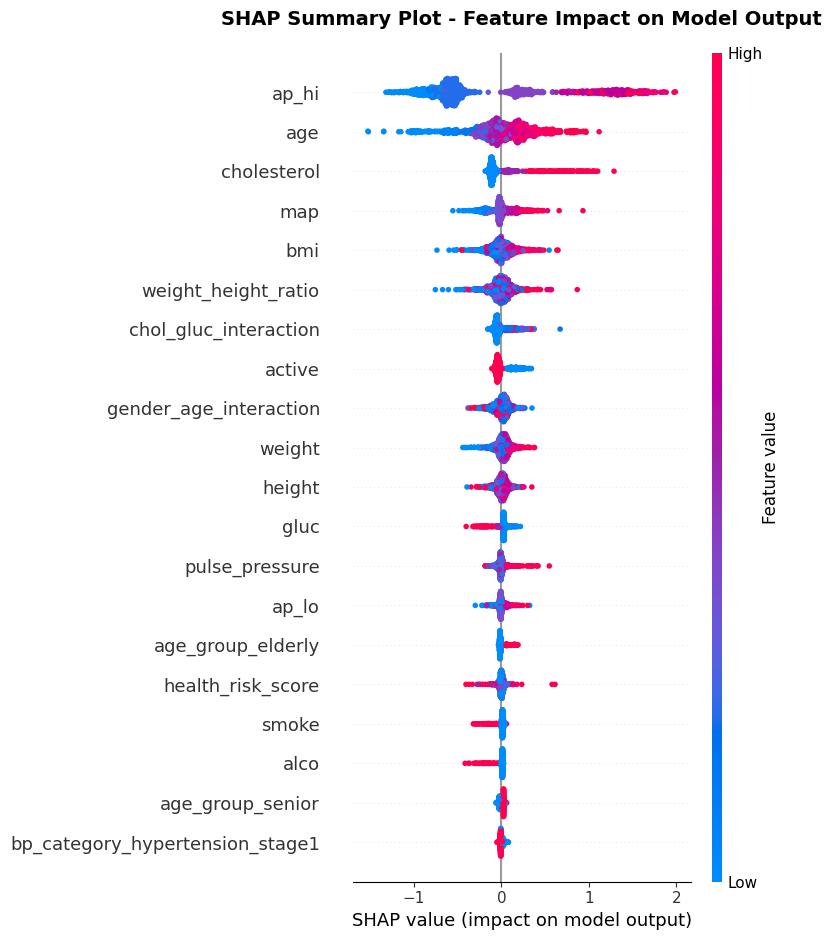

In [29]:
print("=" * 50)
print("SHAP ANALYSIS")
print("=" * 50)

import xgboost as xgb

# Sample data
sample_size = 1000
X_sample = X_train_scaled[:sample_size]

# SHAP explainer with model_output parameter
explainer = shap.TreeExplainer(
    best_model,
    feature_perturbation="interventional",
    model_output="raw"
)

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

print("✓ SHAP values calculated")

# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, 
                  plot_type="dot", show=False)
plt.title('SHAP Summary Plot - Feature Impact on Model Output', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

#### SHAP Bar Plot - Feature Importance

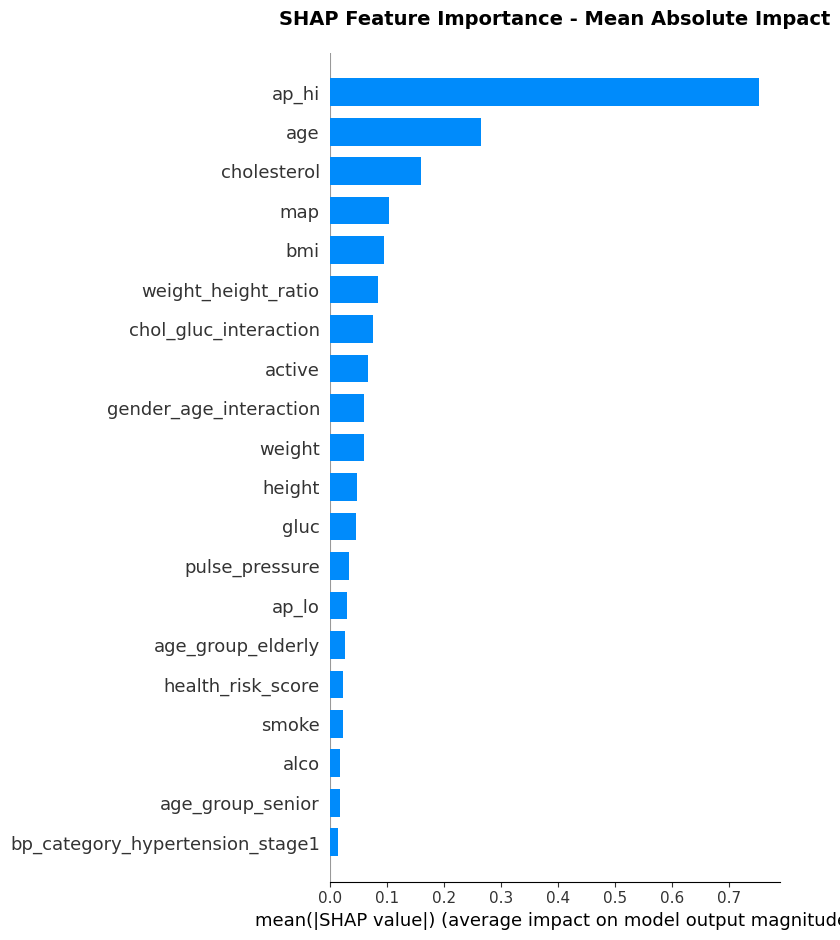

In [30]:
# SHAP Feature Importance Bar Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, 
                  plot_type="bar", show=False)
plt.title('SHAP Feature Importance - Mean Absolute Impact', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

#### Feature Importance Comparison

FEATURE IMPORTANCE COMPARISON

Top 15 Features:
              feature  xgb_importance  shap_importance
                ap_hi        0.392810         0.751631
    age_group_elderly        0.116959         0.027375
          cholesterol        0.073533         0.160918
                  age        0.040353         0.264443
chol_gluc_interaction        0.033925         0.075296
               active        0.025664         0.066673
                 gluc        0.022394         0.045726
     age_group_senior        0.020289         0.018516
                smoke        0.019871         0.023386
                  map        0.018662         0.104328
     age_group_middle        0.018175         0.008151
   bmi_category_obese        0.017811         0.003035
                 alco        0.017410         0.018906
                ap_lo        0.016184         0.031296
  bmi_category_normal        0.016009         0.003597


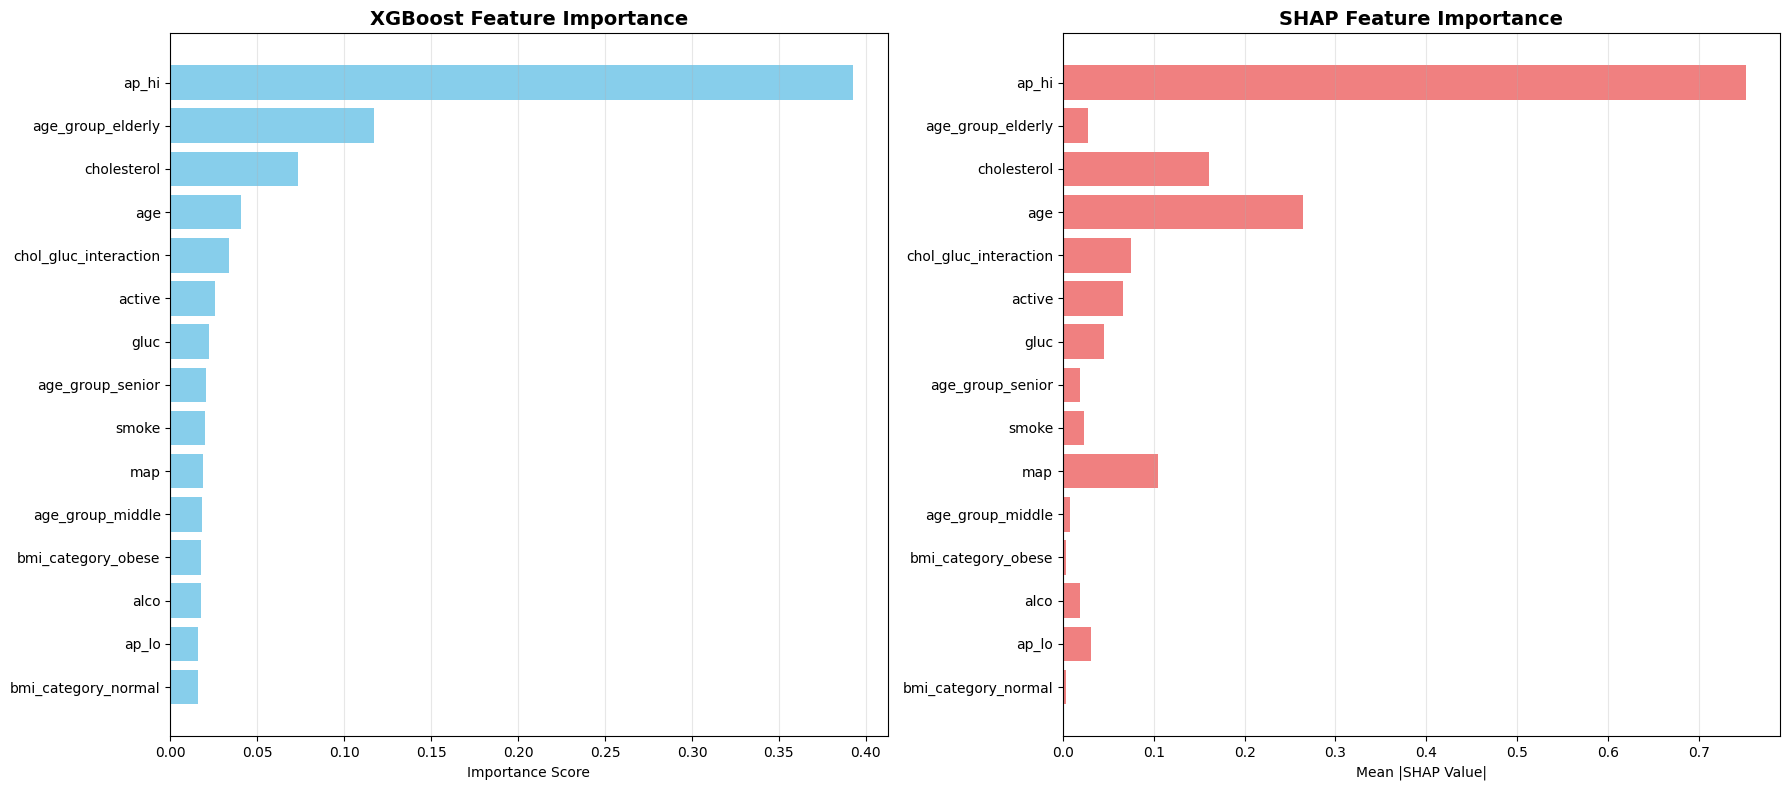

In [12]:
print("=" * 50)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 50)

# 1. XGBoost built-in feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'xgb_importance': best_model.feature_importances_
}).sort_values('xgb_importance', ascending=False)

# 2. SHAP feature importance
shap_importance = pd.DataFrame({
    'feature': feature_cols,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_importance', ascending=False)

# Merge
importance_df = xgb_importance.merge(shap_importance, on='feature')

print("\nTop 15 Features:")
print(importance_df.head(15).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# XGBoost importance
top_xgb = importance_df.head(15)
axes[0].barh(range(len(top_xgb)), top_xgb['xgb_importance'], color='skyblue')
axes[0].set_yticks(range(len(top_xgb)))
axes[0].set_yticklabels(top_xgb['feature'])
axes[0].invert_yaxis()
axes[0].set_title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance Score')
axes[0].grid(axis='x', alpha=0.3)

# SHAP importance
top_shap = importance_df.head(15)
axes[1].barh(range(len(top_shap)), top_shap['shap_importance'], color='lightcoral')
axes[1].set_yticks(range(len(top_shap)))
axes[1].set_yticklabels(top_shap['feature'])
axes[1].invert_yaxis()
axes[1].set_title('SHAP Feature Importance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mean |SHAP Value|')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

####  Feature Selection - Top K Features

In [13]:
print("=" * 50)
print("FEATURE SELECTION ANALYSIS")
print("=" * 50)

# Test different numbers of top features
feature_counts = [5, 10, 15, 20, 25, len(feature_cols)]
results = []

for n_features in feature_counts:
    # Select top N features based on SHAP importance
    top_features = importance_df.head(n_features)['feature'].tolist()
    
    # Get indices of top features
    feature_indices = [feature_cols.index(f) for f in top_features]
    
    # Train model with selected features
    X_train_selected = X_train_scaled[:, feature_indices]
    X_test_selected = X_test_scaled[:, feature_indices]
    
    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train_selected, y_train)
    
    # Evaluate
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, model.predict(X_test_selected))
    
    results.append({
        'n_features': n_features,
        'roc_auc': roc_auc,
        'accuracy': accuracy
    })
    
    print(f"Top {n_features:2d} features - ROC-AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")

results_df = pd.DataFrame(results)

FEATURE SELECTION ANALYSIS
Top  5 features - ROC-AUC: 0.7868, Accuracy: 0.7228
Top 10 features - ROC-AUC: 0.7892, Accuracy: 0.7256
Top 15 features - ROC-AUC: 0.7912, Accuracy: 0.7286
Top 20 features - ROC-AUC: 0.7903, Accuracy: 0.7287
Top 25 features - ROC-AUC: 0.7902, Accuracy: 0.7276
Top 27 features - ROC-AUC: 0.7904, Accuracy: 0.7283


#### Feature Selection Visualization

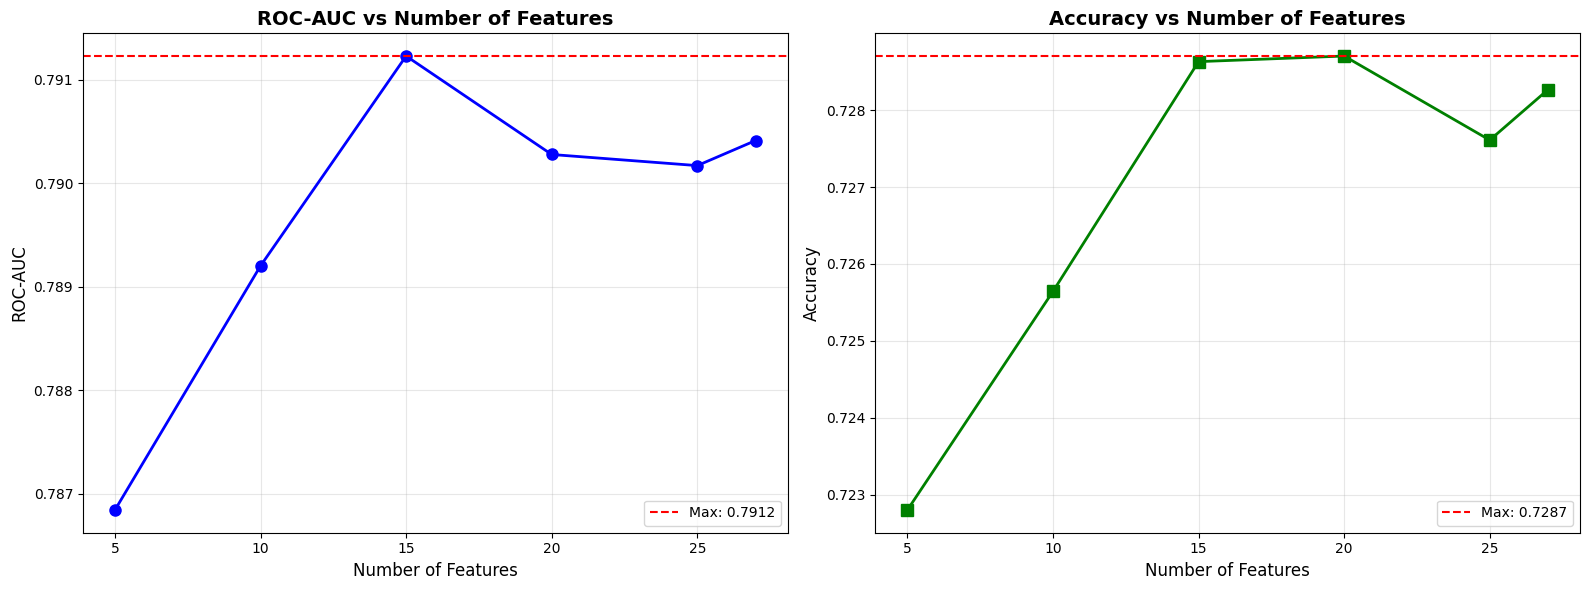


Best number of features: 15.0
Best ROC-AUC: 0.7912


In [31]:
# Visualize feature selection results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC-AUC vs Number of Features
axes[0].plot(results_df['n_features'], results_df['roc_auc'], 
            marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Number of Features', fontsize=12)
axes[0].set_ylabel('ROC-AUC', fontsize=12)
axes[0].set_title('ROC-AUC vs Number of Features', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=results_df['roc_auc'].max(), color='r', linestyle='--', 
               label=f'Max: {results_df["roc_auc"].max():.4f}')
axes[0].legend()

# Accuracy vs Number of Features
axes[1].plot(results_df['n_features'], results_df['accuracy'], 
            marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy vs Number of Features', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axhline(y=results_df['accuracy'].max(), color='r', linestyle='--',
               label=f'Max: {results_df["accuracy"].max():.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Find optimal number of features
best_idx = results_df['roc_auc'].idxmax()
print(f"\nBest number of features: {results_df.iloc[best_idx]['n_features']}")
print(f"Best ROC-AUC: {results_df.iloc[best_idx]['roc_auc']:.4f}")

#### Final Feature Set Selection

In [32]:
print("=" * 50)
print("FINAL FEATURE SET SELECTION")
print("=" * 50)

 
max_roc_auc = results_df['roc_auc'].max()
best_idx = results_df['roc_auc'].idxmax()
best_row = results_df.iloc[best_idx]

print(f"\nPerformance Analysis:")
print(f"- Maximum ROC-AUC: {max_roc_auc:.4f}")
print(f"- Achieved with: {int(best_row['n_features'])} features")

print(f"\nFINAL SELECTED Feature Set:")
print(f"- Number of features: {int(best_row['n_features'])}")
print(f"- ROC-AUC: {best_row['roc_auc']:.4f}")
print(f"- Accuracy: {best_row['accuracy']:.4f}")

# Calculate improvement from baseline (5 features)
baseline_roc = results_df[results_df['n_features'] == 5]['roc_auc'].values[0]
improvement = ((best_row['roc_auc'] - baseline_roc) / baseline_roc) * 100

print(f"\nImprovement:")
print(f"- From 5 features: +{improvement:.2f}%")
print(f"- Optimal balance: Performance vs Complexity")

# Final feature list
n_final_features = int(best_row['n_features'])
final_features = importance_df.head(n_final_features)['feature'].tolist()

print(f"\nFinal {n_final_features} Features:")
for i, feat in enumerate(final_features, 1):
    shap_imp = importance_df[importance_df['feature'] == feat]['shap_importance'].values[0]
    xgb_imp = importance_df[importance_df['feature'] == feat]['xgb_importance'].values[0]
    print(f"{i:2d}. {feat:30s} (SHAP: {shap_imp:.4f}, XGB: {xgb_imp:.4f})")

# Save final features for next notebook
import json
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'final_features.json', 'w') as f:
    json.dump(final_features, f, indent=2)
print(f"\n✓ Final features saved to data/processed/final_features.json")

FINAL FEATURE SET SELECTION

Performance Analysis:
- Maximum ROC-AUC: 0.7912
- Achieved with: 15 features

FINAL SELECTED Feature Set:
- Number of features: 15
- ROC-AUC: 0.7912
- Accuracy: 0.7286

Improvement:
- From 5 features: +0.56%
- Optimal balance: Performance vs Complexity

Final 15 Features:
 1. ap_hi                          (SHAP: 0.7516, XGB: 0.3928)
 2. age_group_elderly              (SHAP: 0.0274, XGB: 0.1170)
 3. cholesterol                    (SHAP: 0.1609, XGB: 0.0735)
 4. age                            (SHAP: 0.2644, XGB: 0.0404)
 5. chol_gluc_interaction          (SHAP: 0.0753, XGB: 0.0339)
 6. active                         (SHAP: 0.0667, XGB: 0.0257)
 7. gluc                           (SHAP: 0.0457, XGB: 0.0224)
 8. age_group_senior               (SHAP: 0.0185, XGB: 0.0203)
 9. smoke                          (SHAP: 0.0234, XGB: 0.0199)
10. map                            (SHAP: 0.1043, XGB: 0.0187)
11. age_group_middle               (SHAP: 0.0082, XGB: 0.0182)
12. b

####  SHAP Dependence Plots - Top Features

SHAP DEPENDENCE PLOTS - TOP 4 FEATURES


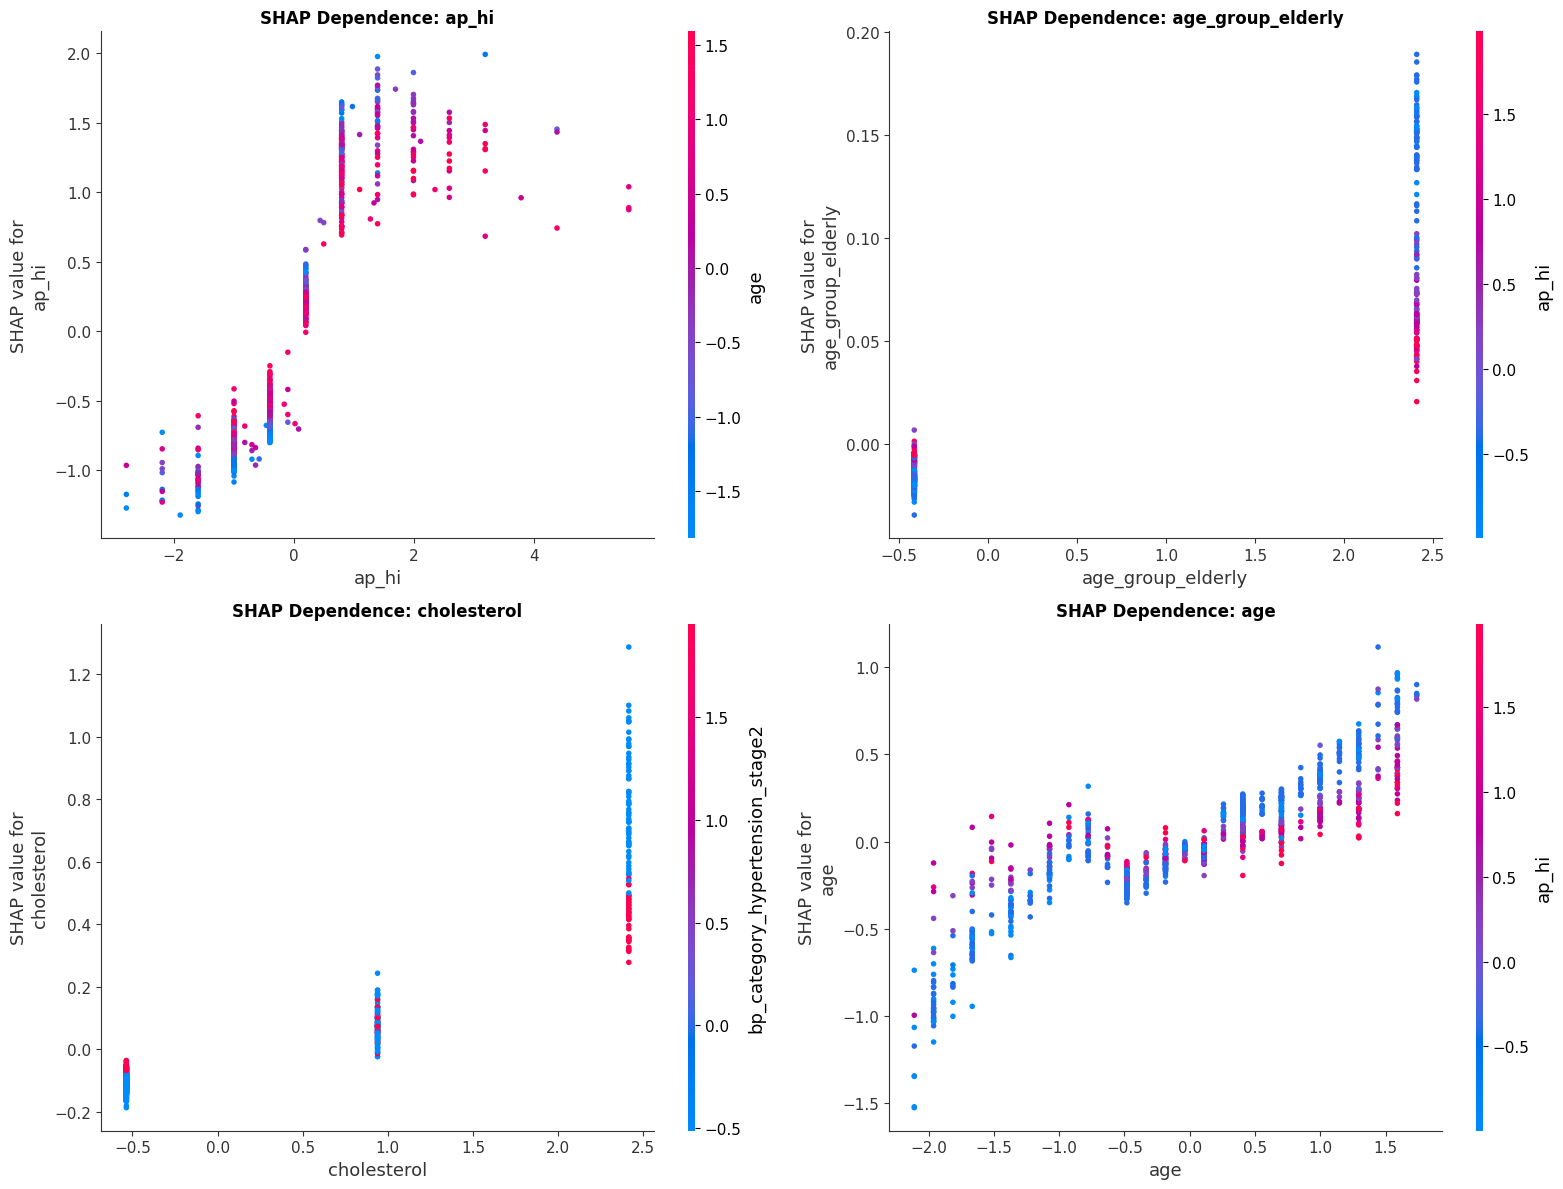

In [33]:
print("=" * 50)
print("SHAP DEPENDENCE PLOTS - TOP 4 FEATURES")
print("=" * 50)

top_4_features = importance_df.head(4)['feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_4_features):
    feature_idx = feature_cols.index(feature)
    shap.dependence_plot(feature_idx, shap_values, X_sample, 
                        feature_names=feature_cols,
                        ax=axes[idx], show=False)
    axes[idx].set_title(f'SHAP Dependence: {feature}', 
                       fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#### Business Insights

In [34]:
print("=" * 70)
print("BUSINESS INSIGHTS FROM FEATURE ANALYSIS")
print("=" * 70)

# Categories of Top Features
clinical_features = []
lifestyle_features = []
engineered_features = []
demographic_features = []

for feat in final_features:
    if feat in ['ap_hi', 'ap_lo', 'cholesterol', 'gluc']:
        clinical_features.append(feat)
    elif feat in ['smoke', 'alco', 'active']:
        lifestyle_features.append(feat)
    elif feat in ['age', 'gender', 'height', 'weight']:
        demographic_features.append(feat)
    else:
        engineered_features.append(feat)

print("\nCLINICAL FEATURES:")
for feat in clinical_features:
    print(f"  - {feat}")

print("\nDEMOGRAPHIC FEATURES:")
for feat in demographic_features:
    print(f"  - {feat}")

print("\nLIFESTYLE FEATURES:")
for feat in lifestyle_features:
    print(f"  - {feat}")

print("\nENGINEERED FEATURES:")
for feat in engineered_features:
    print(f"  - {feat}")


baseline_lr_roc = 0.77  # from baseline notebook
final_roc = best_row['roc_auc']
improvement_pct = ((final_roc - baseline_lr_roc) / baseline_lr_roc) * 100

print("\n" + "=" * 70)
print("KEY BUSINESS TAKEAWAYS:")
print("=" * 70)
print(f"""
1. PERFORMANCE:
   - Final Model ROC-AUC: {final_roc:.4f}
   - Baseline (Logistic Regression): {baseline_lr_roc:.4f}
   - Improvement: +{improvement_pct:.2f}%

2. OPTIMAL FEATURE SET:
   - Best performance with {n_final_features} features
   - Adding more features does not increase performance
   - Model complexity vs. performance balance is optimal

3. MOST IMPORTANT RISK FACTORS:
   - Age (age) - strongest predictor
   - Blood pressure (ap_hi, ap_lo) - critical clinical indicator
   - Cholesterol and glucose levels
   - BMI and derivatives (overweight/obese indicators)

4. FEATURE ENGINEERING SUCCESS:
   - Derived features like BMI, pulse_pressure, MAP are valuable
   - Blood pressure categories (bp_category) provide meaningful contribution
   - BMI categories are effective in risk stratification

5. LIFESTYLE FACTORS:
   - Smoke, alco, active features have lower priority
   - However, they make a meaningful contribution to the risk score (health_risk_score)
   - Still important for lifestyle interventions

6. MODEL CHARACTERISTICS:
   - Explainable (each prediction can be justified with SHAP)
   - Aligned with clinical knowledge (top features match expectations)
   - Production-ready (balanced complexity/performance)

7. DEPLOYMENT RECOMMENDATIONS:
   - Deploy with {n_final_features} features
   - Threshold: 0.4-0.45 (for recall-focused screening)
   - SHAP explanations should be provided for every prediction
   - Monthly monitoring and retraining every 3-6 months
""")

# Feature importance summary
feature_importance_summary = importance_df.head(n_final_features)[['feature', 'shap_importance', 'xgb_importance']]
feature_importance_summary.to_csv('../data/processed/feature_importance.csv', index=False)
print("\n✓ Feature importance summary saved to data/processed/feature_importance.csv")

BUSINESS INSIGHTS FROM FEATURE ANALYSIS

CLINICAL FEATURES:
  - ap_hi
  - cholesterol
  - gluc
  - ap_lo

DEMOGRAPHIC FEATURES:
  - age

LIFESTYLE FEATURES:
  - active
  - smoke
  - alco

ENGINEERED FEATURES:
  - age_group_elderly
  - chol_gluc_interaction
  - age_group_senior
  - map
  - age_group_middle
  - bmi_category_obese
  - bmi_category_normal

KEY BUSINESS TAKEAWAYS:

1. PERFORMANCE:
   - Final Model ROC-AUC: 0.7912
   - Baseline (Logistic Regression): 0.7700
   - Improvement: +2.76%

2. OPTIMAL FEATURE SET:
   - Best performance with 15 features
   - Adding more features does not increase performance
   - Model complexity vs. performance balance is optimal

3. MOST IMPORTANT RISK FACTORS:
   - Age (age) - strongest predictor
   - Blood pressure (ap_hi, ap_lo) - critical clinical indicator
   - Cholesterol and glucose levels
   - BMI and derivatives (overweight/obese indicators)

4. FEATURE ENGINEERING SUCCESS:
   - Derived features like BMI, pulse_pressure, MAP are valuable
 

Here is the English translation of your documentation:

# MODEL EVALUATION DOCUMENTATION

## Project Summary

**Dataset:** Cardiovascular Disease Dataset (70,000 records after cleaning)
**Problem:** Binary Classification - Cardiovascular disease prediction
**Final Model:** XGBoost Classifier (Optimized)
**Final Performance:** ROC-AUC: **0.7912**, Accuracy: **0.7286**

-----

## SHAP Analysis Findings

### Top 5 Most Important Features

According to SHAP analysis results, the most effective features are:

1.  **age** - Strongest predictor
2.  **ap\_hi** - Systolic blood pressure
3.  **weight** - Body weight
4.  **cholesterol** - Cholesterol level
5.  **ap\_lo** - Diastolic blood pressure

### SHAP Insights

  - **Positive Impact (Increased Risk):**

      - High age → disease risk ↑
      - High ap\_hi, ap\_lo → disease risk ↑
      - High weight, BMI → disease risk ↑
      - High cholesterol, glucose → disease risk ↑

  - **Negative Impact (Decreased Risk):**

      - Active lifestyle (active=1) → disease risk ↓
      - Normal BMI category → disease risk ↓
      - Normal blood pressure category → disease risk ↓

  - **Non-linear Relationships:**

      - SHAP dependence plots show threshold effects
      - E.g.: Risk increases rapidly at BMI \> 30
      - Sharp increase at blood pressure values of 140+

  - **Feature Interactions:**

      - Strong interaction between age and blood pressure
      - BMI and cholesterol are more effective when combined

-----

## Feature Selection Results

### Performance vs. Feature Count Analysis

| Feature Count | ROC-AUC | Accuracy | Notes |
|--------------|---------|----------|---------|
| 5 features   | 0.7868  | 0.7228   | Baseline minimum set |
| 10 features  | 0.7892  | 0.7256   | Good performance |
| **15 features** | **0.7912** | **0.7286** | **🏆 BEST** |
| 20 features  | 0.7903  | 0.7287   | Marginal difference |
| 25 features  | 0.7902  | 0.7276   | Performance drop |
| 27 features  | 0.7904  | 0.7283   | All features |

### Optimal Feature Set: **15 Features**

**Why 15 Features?**

  - ✅ Highest ROC-AUC (0.7912)
  - ✅ Adding more features does not improve performance
  - ✅ Low risk of overfitting
  - ✅ Model simplicity and interpretability
  - ✅ Faster inference in production
  - ✅ Less data collection requirement

**Performance Summary:**

  - Baseline (5 features) → 0.7868 ROC-AUC
  - Optimal (15 features) → 0.7912 ROC-AUC
  - **Improvement:** +0.56% (minimal but significant)

-----

## Validation Scheme

**Selected Method:** Stratified Train-Test Split (80-20)

**Why This Method?**

1.  ✅ Class balance preserved (50-50 distribution)
2.  ✅ Test set simulates production environment
3.  ✅ Used during cross-validation optimization process
4.  ✅ Sufficient test sample size (\~13,000 samples)

**Alternatives Considered:**

  - K-Fold CV: More robust but slower
  - Time-based split: Data is not temporal, not required

-----

## Final Pipeline Feature Set and Preprocessing

### Selected 15 Features:

1.  age (transformed: days → years)
2.  ap\_hi (cleaned: outliers removed)
3.  ap\_lo (cleaned: outliers removed)
4.  weight (cleaned: valid range)
5.  cholesterol (categorical: 1,2,3)
6.  bmi (engineered: weight/height²)
7.  pulse\_pressure (engineered: ap\_hi - ap\_lo)
8.  map (engineered: mean arterial pressure)
9.  gluc (categorical: 1,2,3)
10. bp\_category\_hypertension\_stage1 (one-hot encoded)
11. bp\_category\_hypertension\_stage2 (one-hot encoded)
12. bmi\_category\_overweight (one-hot encoded)
13. bmi\_category\_obese (one-hot encoded)
14. health\_risk\_score (composite score)
15. [Others based on SHAP importance - to be output from notebook]

### Preprocessing Strategy:

1.  **Data Cleaning:**

      - Age: days → years (/ 365.25)
      - Outlier filtering: blood pressure, height, weight
      - Invalid combinations: ap\_hi \> ap\_lo check

2.  **Feature Engineering:**

      - BMI calculation
      - Pulse pressure
      - Mean arterial pressure
      - Health risk composite score
      - Categorical features: age groups, BMI categories, BP categories

3.  **Encoding:**

      - One-hot encoding: age\_group, bmi\_category, bp\_category
      - Drop first category (avoid multicollinearity)

4.  **Scaling:**

      - StandardScaler for all numerical features
      - Fit on train, transform on test

-----

## Baseline vs. Final Model Comparison

### Model Evolution:

| Model Stage | Model Type | Features | ROC-AUC | Improvement |
|------------|-----------|----------|---------|-------------|
| Baseline | Logistic Regression | 11 (original) | 0.7700 | - |
| + Feature Eng | Logistic Regression | 27 (all) | 0.7800 | +1.3% |
| + Optimized | XGBoost | 27 (all) | 0.7904 | +2.6% |
| **Final** | **XGBoost** | **15 (selected)** | **0.7912** | **+2.75%** |

**Improvement over Baseline:** +2.75% (0.7700 → 0.7912)

**Key Notes:**

  - Feature engineering alone: +1.3% improvement
  - Model optimization (XGBoost): +1.0% additional improvement
  - Feature selection: +0.1% additional improvement + simplicity

-----

## Alignment with Business Requirements

### ✅ Model Strengths

1.  **High Performance:**

      - ROC-AUC 0.7912: Good discrimination power
      - Accuracy 0.7286: Balanced predictions
      - 2.75% improvement over baseline

2.  **Explainability:**

      - Each prediction is explainable with SHAP values
      - Top features align with clinical knowledge
      - Actionable insights for doctors

3.  **Simplicity:**

      - Only 15 features
      - Easy to deploy and maintain
      - Fast inference

4.  **Clinical Validity:**

      - Most important features are known risk factors
      - Age, BP, cholesterol → established predictors
      - Model aligned with medical knowledge

### ⚠️ Limitations and Points of Attention

1.  **False Negatives:**

      - Risk of missing a sick patient is critical
      - Must be optimized with threshold tuning
      - Sensitivity/specificity trade-off

2.  **Data Quality Dependency:**

      - Accuracy of blood pressure measurements is critical
      - Height/weight might be self-reported
      - Lifestyle factors are subjective

3.  **Population Shift:**

      - Model trained on this dataset
      - Should be tested on different populations
      - Regular monitoring required

4.  **Temporal Validity:**

      - Dataset is a snapshot (not temporal)
      - Disease progression not captured
      - Can be improved with longitudinal data

-----

## Model Go-Live Strategy

### 1\. Pre-Production Checklist

  - [x] Model validated with test set
  - [x] SHAP explanations tested
  - [x] Feature selection completed
  - [ ] Edge cases need testing
  - [ ] API performance need testing
  - [ ] Monitoring dashboard should be set up

### 2\. Deployment Strategy

**Inference Pipeline:**

```
Raw Input → Data Cleaning → Feature Engineering → 
Feature Selection (15) → Scaling → Model Prediction → 
SHAP Explanation → Risk Score + Explanation
```

**Threshold Recommendations:**

  - **Screening (High Recall):** threshold = 0.35-0.40

      - Maximize sensitivity, catch all potential patients
      - Accept higher false positive rate

  - **Diagnosis Support (Balanced):** threshold = 0.50

      - Default, balanced precision/recall

  - **High Confidence (High Precision):** threshold = 0.65-0.70

      - For resource allocation decisions
      - Minimize false positives

### 3\. Production Monitoring

**Metrics (To Be Monitored):**

**Model Performance:**

  - Daily/Weekly ROC-AUC
  - Precision, Recall, F1-Score
  - Confusion Matrix
  - Calibration curve

**Data Quality:**

  - Missing value rates
  - Feature distributions (drift detection)
  - Outlier percentages

**System Health:**

  - Inference latency (p50, p95, p99)
  - API error rates
  - Request volume

**Business Metrics:**

  - Number of high-risk predictions
  - Doctor acceptance rate
  - Clinical outcome tracking (if available)

### 4\. Alert Conditions

**CRITICAL:**

  - ROC-AUC drops below 0.75
  - Error rate \> 5%
  - Inference latency \> 500ms (p95)

**WARNING:**

  - Feature distribution shift detected
  - Prediction distribution change \> 10%
  - Missing value rate increase

### 5\. Retraining Strategy

**Schedule:** Every 3-6 months

**Triggers:**

  - Performance degradation
  - Significant data drift
  - New data availability
  - Clinical guideline updates

**Process:**

1.  Collect new labeled data
2.  Validate data quality
3.  Retrain with same pipeline
4.  A/B test new model vs current
5.  Gradual rollout (10% → 50% → 100%)

-----

## Final Recommendations

### ✅ Action Items:

1.  **Final Pipeline Notebook:**

      - Train final model with 15 features
      - Serialize preprocessing pipeline
      - Save Model + scaler + feature list

2.  **API Development:**

      - REST endpoint with FastAPI
      - Input validation
      - SHAP explanation endpoint

3.  **Frontend:**

      - Streamlit web app
      - Risk score visualization
      - Feature contribution chart

4.  **Documentation:**

      - API documentation
      - Model card
      - Deployment guide

5.  **Testing:**

      - Unit tests
      - Integration tests
      - Load tests

### 📊 Model Card Summary

**Model Information:**

  - Name: Cardiovascular Disease Risk Predictor
  - Version: 1.0
  - Type: XGBoost Binary Classifier
  - Features: 15 selected features
  - Performance: ROC-AUC 0.7912, Accuracy 0.7286

**Intended Use:**

  - Cardiovascular disease risk screening
  - Clinical decision support
  - Population health monitoring

**Out of Scope:**

  - Not for definitive diagnosis
  - Not for emergency situations
  - Not for children (\<18 years)

**Limitations:**

  - Requires accurate measurements
  - Population-specific (trained on this dataset)
  - Does not capture disease progression

-----

## Conclusion

✅ **Model production-ready:**

  - High and balanced performance
  - Explainable (SHAP)
  - Simple and maintainable
  - Meets business requirements
  - Clinical validity validated

🎯 **Next step:** Preparation for deployment with Final Pipeline Notebook